# import 

In [3]:
import toml
import json
import time
import torch
import pickle
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Module,Identity,Sequential
from typing import Dict,Tuple
from ecode.m6Anet.blocks import PoolingFilter
from sklearn.metrics import roc_auc_score

# DataLoader

In [4]:
class m6AnetDataset(data.Dataset):
    def __init__(self,path,use_file):
        samples_dic={}
        k5_list=[]
        with open(path+'/'+use_file+'.txt','r') as f:
            for line in f.readlines():
                f_name,label=line.strip().split()
                with open(path+'/'+f_name+'.index') as f2:
                    for line2 in f2.readlines():
                        sample,start,end=line2.strip().split('\t')
                        if sample not in samples_dic:
                            samples_dic[sample]=[]
                        samples_dic[sample].append((f_name,int(start),int(end),int(label)))
                        with open(path+'/'+f_name+'.json') as f:
                            f.seek(int(start),0)
                            json_str=f.read(int(end)-int(start))
                            Ls=json_str.strip().split('\n')
                            k_str=json.loads(Ls[0])
                            for k5 in [k_str[9:14],k_str[10:15],k_str[11:16]]:
                                if k5 not in k5_list:
                                    k5_list.append(k5)
        print('total',len(k5_list),' possible k5 as:')
        print(k5_list)
        self.k5_list=np.array(k5_list)
        
        self.path=path
        self.samples_keys=list(samples_dic.keys())
        self.samples_dic=samples_dic

    def __getitem__(self,index):
        R_dicts=[]
        for single_sample in self.samples_dic[self.samples_keys[index]]:
            file,seek_start,seek_end,label=single_sample
            R_dict={'X':[],'kmer':[],'label':label}
            with open(self.path+'/'+file+'.json') as f:
                f.seek(seek_start,0)
                json_str=f.read(seek_end-seek_start)
                Ls=json_str.strip().split('\n')
                k_str=json.loads(Ls[0])
                for k5 in [k_str[9:14],k_str[10:15],k_str[11:16]]:
                    R_dict['kmer'].append(np.where(self.k5_list==k5)[0][0])
                for L in Ls[1:]:
                    L_data=json.loads(L)
                    t_feature=[]
                    for each in L_data[11:14]:
                        if each[0]<0:
                            t_feature.extend([0,0,0])
                        else:
                            t_feature.extend(each)
                    R_dict['X'].append(t_feature)
            for key in R_dict:
                R_dict[key]=torch.tensor(R_dict[key])
            R_dict['kmer']=R_dict['kmer'].repeat(len(R_dict['X']),1)
            R_dicts.append(R_dict)
        return R_dicts                
    def __len__(self):
        return len(self.samples_dic)

class FlattenedDataset(data.Dataset):
    def __init__(self,original_dataset):
        self.flattened_data=[]
        for data in original_dataset:
            self.flattened_data.extend(data)
    def __len__(self):
        return len(self.flattened_data)
    def __getitem__(self,index):
        if isinstance(index,(list,np.ndarray)):
            return [self.flattened_data[i] for i in index]
        else:
            return self.flattened_data[index]

In [5]:
dataset=m6AnetDataset('./edata/DataSet/m6A','use_files')
print(len(dataset))
K5_TYPES=len(dataset.k5_list)

total 66  possible k5 as:
['TAAAC', 'AAACT', 'AACTG', 'AGAAC', 'GAACA', 'AACAT', 'TGAAC', 'GGGAC', 'GGACT', 'GACTG', 'CAGAC', 'AGACC', 'GACCT', 'CGGAC', 'GGACA', 'GACAG', 'AGGAC', 'GACTT', 'TAGAC', 'AGACT', 'GAACC', 'AACCC', 'GAACT', 'AACTC', 'GGACC', 'GACCG', 'TGGAC', 'GACTA', 'GACTC', 'CTAAC', 'TAACT', 'AACTT', 'ATGAC', 'TGACC', 'GACCC', 'AACCG', 'CAAAC', 'GAGAC', 'AAGAC', 'TGACT', 'AACAG', 'GGAAC', 'AACAA', 'GACAC', 'GACAT', 'TTGAC', 'GAAAC', 'AGACA', 'CGAAC', 'CTGAC', 'GACAA', 'AACCT', 'GACCA', 'GTGAC', 'AAAAC', 'AACTA', 'TGACA', 'ATAAC', 'TTAAC', 'AACAC', 'AACCA', 'AAACA', 'GTAAC', 'AAACC', 'TAACC', 'TAACA']
3836


In [6]:
RELOAD=0
if RELOAD==1:
    dataset=m6AnetDataset('./edata/DataSet/m6A','use_files')
    train_size=int(len(dataset)*0.8)
    test_size=len(dataset)-train_size
    train_set,test_set=torch.utils.data.random_split(dataset,[train_size,test_size])
    flattened_train_set=FlattenedDataset(train_set)
    flattened_test_set=FlattenedDataset(test_set)
    print('len(flattened_train_set)',len(flattened_train_set))
    print('len(flattened_test_set)',len(flattened_test_set))

    with open('./edata/Save_DataSet/m6A_m6Anet_train_set.pkl','wb') as f:
        pickle.dump(flattened_train_set,f)
    with open('./edata/Save_DataSet/m6A_m6Anet_test_set.pkl','wb') as f:
        pickle.dump(flattened_test_set,f)
    train_loader=DataLoader(flattened_train_set,batch_size=5,shuffle=True)
    test_loader=DataLoader(flattened_test_set,batch_size=5,shuffle=True)
else:
    with open('./edata/Save_DataSet/m6A_m6Anet_train_set.pkl','rb') as f:
        flattened_train_set=pickle.load(f)
    with open('./edata/Save_DataSet/m6A_m6Anet_test_set.pkl','rb') as f:
        flattened_test_set=pickle.load(f)
    print('len(flattened_train_set)',len(flattened_train_set))
    print('len(flattened_test_set)',len(flattened_test_set))
    
    train_loader=DataLoader(flattened_train_set,batch_size=5,shuffle=True)
    test_loader=DataLoader(flattened_test_set,batch_size=5,shuffle=True)

len(flattened_train_set) 5087
len(flattened_test_set) 1292


# model

In [7]:
class MILModel(Module):
    def __init__(self,model_config):
        super(MILModel,self).__init__()
        self.model_config=model_config
        self.read_level_encoder=None
        self.pooling_filter=None
        self.decoder=None
        self.build_model()

    def build_model(self):
        blocks=self.model_config['block']
        seq_model=[]
        for block in blocks:
            block_type=block.pop('block_type')
            block_obj=self._build_block(block_type,**block)

            if isinstance(block_obj,PoolingFilter):
                if len(seq_model)>0:
                    self.read_level_encoder=Sequential(*seq_model)
                else:
                    self.read_level_encoder=None

                self.pooling_filter=block_obj
                seq_model=[]
            else:
                seq_model.append(block_obj)

        if (self.read_level_encoder is None) and (self.pooling_filter is None):
            self.read_level_encoder=Sequential(*seq_model)
            self.pooling_filter=Identity()
            self.decoder=Identity()
        else:
            if len(seq_model)==0:
                self.decoder=Identity()
            else:
                self.decoder=Sequential(*seq_model)

    def _build_block(self,block_type,**kwargs):
        from ecode.m6Anet import blocks
        block_obj=getattr(blocks,block_type)
        return block_obj(**kwargs)

    def get_read_representation(self,x):
        if self.read_level_encoder is None:
            return x
        else:
            return self.read_level_encoder(x)

    def get_read_probability(self,x):
        read_representation=self.get_read_representation(x)
        return self.pooling_filter.predict_read_level_prob(read_representation)

    def get_site_representation(self,x):
        return self.pooling_filter(self.get_read_representation(x))

    def get_site_probability(self,x):
        return self.decoder(self.get_site_representation(x))

    def get_read_site_probability(self,x):
        read_representation=self.get_read_representation(x)
        read_level_probability=self.pooling_filter.predict_read_level_prob(read_representation)
        site_level_probability=self.decoder(self.pooling_filter(read_representation))
        return read_level_probability,site_level_probability,read_representation

    def get_attention_weights(self,x):
        if hasattr(self.pooling_filter, "get_attention_weights"):
            return self.pooling_filter.get_attention_weights(self.get_read_representation(x))
        else:
            raise ValueError("Pooling filter does not have attention weights")

    def forward(self,x):
        if type(x) is np.ndarray:
            probs=torch.tensor([]).to(x[0]['X'].device)
            for sub_x in x:
                sub_x={k:v.unsqueeze(0) for k,v in sub_x.items()}
                prob=self.get_site_probability(sub_x).unsqueeze(0)
                probs=torch.cat((probs,prob.unsqueeze(0)),dim=0)
        else:
            probs=self.get_site_probability(x)
        return probs

# For Train and Test

In [6]:
def test(model,test_loader,device,read_reduce=0):
    model.eval()
    right_count,all_count=0,0
    prob_all,Y_all=[],[]
    with torch.no_grad():
        for _,l_dic in enumerate(test_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label'].to(torch.int64)
            l_dic['X']=l_dic['X'][:,read_reduce:]
            l_dic['kmer']=l_dic['kmer'][:,read_reduce:]
            pre_y=model(l_dic)
            out_y=pre_y>0.5
            right_count+=out_y.eq(data_y).sum()
            all_count+=len(data_y)
            for each in pre_y:
                prob_all.append(np.array(each.cpu()))
            for each in data_y:
                Y_all.append(np.array(each.cpu()))
    roauc=roc_auc_score(Y_all,prob_all)

    accuracy=100*(right_count/all_count).item()
    print('AUC:{:.4f}   accuracy:{:.4f}%'.format(roauc,accuracy))
    torch.cuda.empty_cache()

def train(model,train_loader,test_loader,device,optimizer,loss_func,epochs,read_reduce=0):
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        total_loss=0
        model.train()
        for _,l_dic in enumerate(train_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label']
            l_dic['X']=l_dic['X'][:,read_reduce:]
            l_dic['kmer']=l_dic['kmer'][:,read_reduce:]
            pre_y=model(l_dic)
            loss=loss_func(pre_y,data_y.float())
            total_loss+=loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('epoch {}, loss:{:.4f}'.format(epoch+1,total_loss.item()/len(train_loader)))
        if epoch%10==9:
            print('At epoch '+str(epoch+1),':')
            test(model,test_loader,device,read_reduce)
            torch.save(model.state_dict(),'./model/model_'+str(epoch+1)+'_'+str(int(time.time()))+'.pkl')

In [7]:
def detailed_test(model,test_loader,device,read_reduce=0,curve_name=None):
    model.eval()
    right_count,all_count=0,0
    more_dict={0.5:[0,0],0.6:[0,0],0.8:[0,0],0.7:[0,0],0.9:[0,0],0.95:[0,0],0.98:[0,0],\
               0.99:[0,0],0.995:[0,0],0.999:[0,0],0.9995:[0,0],0.9999:[0,0],0.99995:[0,0],\
               0.99999:[0,0],0.999995:[0,0],0.999999:[0,0]}
    prob_all,Y_all=[],[]
    motif_found_dict={}
    motif_dict={}
    with torch.no_grad():
        for _,l_dic in enumerate(test_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label'].to(torch.int64)
            l_dic['X']=l_dic['X'][:,read_reduce:]
            l_dic['kmer']=l_dic['kmer'][:,read_reduce:]
            pre_y=model(l_dic)
            out_y=pre_y>0.5
            right_count+=out_y.eq(data_y).sum()
            all_count+=len(data_y)
            for each in pre_y:
                prob_all.append(np.array(each.cpu()))
            for each in data_y:
                Y_all.append(np.array(each.cpu()))
            for key in more_dict:
                more_dict[key][0]+=((pre_y>key)&data_y).sum()
                more_dict[key][1]+=(pre_y>key).sum()
    if curve_name:
        save_frame=pd.DataFrame({'label':Y_all,'pred':prob_all})
        save_frame.to_csv('./edata/Save_for_drawing/'+curve_name+'_curve.csv',index=False,sep=',')

    print('Im total',all_count,'samples:')
    auc=roc_auc_score(Y_all,prob_all)
    accuracy=100*(right_count/all_count).item()
    print('AUC:{:.4f}   accuracy:{:.4f}%'.format(auc,accuracy))
    for key in more_dict:
        if more_dict[key][1]>0:
            print('Precision when positive threshold at {:g} is :{:.4f}% (total:{:d})'.format(key,more_dict[key][0]/more_dict[key][1],more_dict[key][1]))
    torch.cuda.empty_cache()

# Train

In [15]:
config_file_20reads='./ecode/m6Anet/m6Anet_20reads.toml'
model_config_20reads=toml.load(config_file_20reads)
model_config_20reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model=MILModel(model_config_20reads).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=300
train(model,train_loader,test_loader,device,optimizer,loss_func,epochs,read_reduce=30)

epoch 1, loss:0.7550
epoch 2, loss:0.6505
epoch 3, loss:0.6288
epoch 4, loss:0.6153
epoch 5, loss:0.6060
epoch 6, loss:0.6026
epoch 7, loss:0.5939
epoch 8, loss:0.5908
epoch 9, loss:0.5848
epoch 10, loss:0.5844
At epoch 10 :
AUC:0.7219   accuracy:65.7895%
epoch 11, loss:0.5769
epoch 12, loss:0.5728
epoch 13, loss:0.5704
epoch 14, loss:0.5620
epoch 15, loss:0.5613
epoch 16, loss:0.5576
epoch 17, loss:0.5571
epoch 18, loss:0.5529
epoch 19, loss:0.5456
epoch 20, loss:0.5456
At epoch 20 :
AUC:0.7667   accuracy:69.9690%
epoch 21, loss:0.5409
epoch 22, loss:0.5398
epoch 23, loss:0.5385
epoch 24, loss:0.5328
epoch 25, loss:0.5341
epoch 26, loss:0.5328
epoch 27, loss:0.5274
epoch 28, loss:0.5223
epoch 29, loss:0.5250
epoch 30, loss:0.5205
At epoch 30 :
AUC:0.7969   accuracy:71.6718%
epoch 31, loss:0.5213
epoch 32, loss:0.5175
epoch 33, loss:0.5128
epoch 34, loss:0.5133
epoch 35, loss:0.5113
epoch 36, loss:0.5099
epoch 37, loss:0.5091
epoch 38, loss:0.5138
epoch 39, loss:0.5098
epoch 40, loss:0

In [16]:
config_file_50reads='./ecode/m6Anet/m6Anet_50reads.toml'
model_config_50reads=toml.load(config_file_50reads)
model_config_50reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model=MILModel(model_config_50reads).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=300
train(model,train_loader,test_loader,device,optimizer,loss_func,epochs)

epoch 1, loss:4.6088
epoch 2, loss:2.6681
epoch 3, loss:1.5778
epoch 4, loss:0.8146
epoch 5, loss:0.6768
epoch 6, loss:0.6547
epoch 7, loss:0.6444
epoch 8, loss:0.6347
epoch 9, loss:0.6250
epoch 10, loss:0.6132
At epoch 10 :
AUC:0.6832   accuracy:62.1517%
epoch 11, loss:0.5998
epoch 12, loss:0.5876
epoch 13, loss:0.5815
epoch 14, loss:0.5768
epoch 15, loss:0.5734
epoch 16, loss:0.5725
epoch 17, loss:0.5697
epoch 18, loss:0.5640
epoch 19, loss:0.5633
epoch 20, loss:0.5610
At epoch 20 :
AUC:0.7237   accuracy:64.6285%
epoch 21, loss:0.5611
epoch 22, loss:0.5551
epoch 23, loss:0.5550
epoch 24, loss:0.5544
epoch 25, loss:0.5491
epoch 26, loss:0.5513
epoch 27, loss:0.5471
epoch 28, loss:0.5455
epoch 29, loss:0.5441
epoch 30, loss:0.5402
At epoch 30 :
AUC:0.7356   accuracy:65.4025%
epoch 31, loss:0.5383
epoch 32, loss:0.5366
epoch 33, loss:0.5378
epoch 34, loss:0.5342
epoch 35, loss:0.5352
epoch 36, loss:0.5343
epoch 37, loss:0.5306
epoch 38, loss:0.5312
epoch 39, loss:0.5329
epoch 40, loss:0

# Test

In [10]:
config_file_20reads='./ecode/m6Anet/m6Anet_20reads.toml'
model_config_20reads=toml.load(config_file_20reads)
model_config_20reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model=MILModel(model_config_20reads).to(device)
model.load_state_dict(torch.load('./model/m6Anet_240_20reads_3sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,read_reduce=30,curve_name='m6Anet,20reads_3sites')

Im total 1292 samples:
AUC:0.8271   accuracy:75.0000%
Precision when positive threshold at 0.5 is :0.7379% (total:847)
Precision when positive threshold at 0.6 is :0.7733% (total:750)
Precision when positive threshold at 0.8 is :0.8490% (total:510)
Precision when positive threshold at 0.7 is :0.8128% (total:657)
Precision when positive threshold at 0.9 is :0.8917% (total:351)
Precision when positive threshold at 0.95 is :0.9163% (total:227)
Precision when positive threshold at 0.98 is :0.9478% (total:115)
Precision when positive threshold at 0.99 is :0.9487% (total:78)
Precision when positive threshold at 0.995 is :0.9362% (total:47)
Precision when positive threshold at 0.999 is :0.7692% (total:13)
Precision when positive threshold at 0.9995 is :0.7500% (total:12)
Precision when positive threshold at 0.9999 is :0.5000% (total:2)
Precision when positive threshold at 0.99995 is :1.0000% (total:1)


In [60]:
config_file_50reads='./ecode/m6Anet/m6Anet_50reads.toml'
model_config_50reads=toml.load(config_file_50reads)
model_config_50reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model=MILModel(model_config_50reads).to(device)
model.load_state_dict(torch.load('./model/m6Anet_140_50reads_3sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,read_reduce=0,curve_name='m6Anet,50reads_3sites')

Im total 1292 samples:
AUC:0.7967   accuracy:71.4396%
Precision when positive threshold at 0.5 is :0.7059% (total:867)
Precision when positive threshold at 0.6 is :0.7428% (total:762)
Precision when positive threshold at 0.8 is :0.8539% (total:486)
Precision when positive threshold at 0.7 is :0.7921% (total:630)
Precision when positive threshold at 0.9 is :0.8731% (total:323)
Precision when positive threshold at 0.95 is :0.9078% (total:217)
Precision when positive threshold at 0.98 is :0.9173% (total:133)
Precision when positive threshold at 0.99 is :0.9101% (total:89)
Precision when positive threshold at 0.995 is :0.9298% (total:57)
Precision when positive threshold at 0.999 is :0.9000% (total:30)
Precision when positive threshold at 0.9995 is :0.9200% (total:25)
Precision when positive threshold at 0.9999 is :0.8824% (total:17)
Precision when positive threshold at 0.99995 is :0.8571% (total:14)
Precision when positive threshold at 0.99999 is :0.8571% (total:7)
Precision when positive

# Shap explain import

In [11]:
import shap
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import RobustScaler,MinMaxScaler

import ecode.explainer.m6AnetExp
import importlib
importlib.reload(ecode.explainer.m6AnetExp)
from ecode.explainer.m6AnetExp import m6Anet_DeepEXP

shap.initjs()
np.set_printoptions(precision=6)

In [12]:
def gini_coefficient(x_array):
    x=torch.tensor(x_array.copy())
    sorted_x,_=torch.sort(x)
    n=x.size(0)
    
    cum_x=torch.cumsum(sorted_x, dim=0)

    gini_numerator=(2*torch.arange(1,n+1,dtype=x.dtype,device=x.device)*sorted_x).sum()
    gini_denominator=n*cum_x[-1]

    gini_coefficient=(gini_numerator/gini_denominator)-(n+1)/n
    return gini_coefficient

In [13]:
print(len(flattened_train_set),len(flattened_test_set))

5087 1292


# Shap explain 20reads

In [34]:
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
read_reduce=30

background_set_20reads=[]
sample_set_20reads=[]

background_set_size=1000
sample_set_size=200
shuffled_flattened_train_set=flattened_train_set[random.sample(range(len(flattened_train_set)),background_set_size)]
shuffled_flattened_test_set=flattened_test_set[random.sample(range(len(flattened_test_set)),sample_set_size)]

for i in range(background_set_size):
    ap_dic=shuffled_flattened_train_set[i].copy()
    for k,v in ap_dic.items():
        if k=='X' or k=='kmer':
            v=v[read_reduce:]
        v=v.to(device)
        ap_dic[k]=v
    background_set_20reads.append(ap_dic)

for i in range(sample_set_size):
    ap_dic=shuffled_flattened_test_set[i].copy()
    for k,v in ap_dic.items():
        if k=='X' or k=='kmer':
            v=v[read_reduce:]
        v=v.to(device)
        ap_dic[k]=v
    sample_set_20reads.append(ap_dic)

background_set_20reads=np.array(background_set_20reads)
sample_set_20reads=np.array(sample_set_20reads)

In [35]:
config_file_20reads='./ecode/m6Anet/m6Anet_20reads.toml'
model_config_20reads=toml.load(config_file_20reads)
model_config_20reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model_20reads=MILModel(model_config_20reads).to(device)
model_20reads.load_state_dict(torch.load('./model/m6Anet_240_20reads_3sites.pkl',weights_only=True))

<All keys matched successfully>

In [36]:
explainer_20reads=m6Anet_DeepEXP(model_20reads,background_set_20reads)
shap_values_20reads=explainer_20reads.shap_values(sample_set_20reads)
shap_values_20reads=np.array(shap_values_20reads[0])
shap_values_20reads=shap_values_20reads.reshape(shap_values_20reads.shape[:-1])

[6.306194e-01 1.741457e-01 8.164712e-02 3.790598e-02 2.529633e-02
 1.578703e-02 1.071474e-02 7.844990e-03 5.300277e-03 3.597001e-03
 2.174671e-03 1.532282e-03 1.216910e-03 8.871732e-04 6.098652e-04
 4.369144e-04 2.309820e-04 4.628708e-05 6.318925e-06 0.000000e+00]


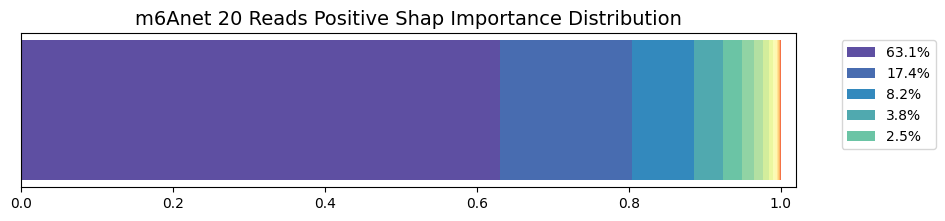

positive shap gini for 20reads is: 0.8590317


In [45]:
shap_use=shap_values_20reads.copy()
shap_use[shap_values_20reads<0]=0
row_sums=shap_use.sum(axis=1,keepdims=True)
row_sums[row_sums==0]=1
normalized_shap_use=shap_use/row_sums
sorted_normalized_shap_use=np.sort(normalized_shap_use,axis=1)[:,::-1]

#importance distribution by the top N most important read by positive shap
importance_20reads=sorted_normalized_shap_use.sum(axis=0,keepdims=False)/normalized_shap_use.sum()
print(importance_20reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_20reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_20reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_xlim([0,1.02])
ax.set_title('m6Anet 20 Reads Positive Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/m6Anet_positive_shap_distribution_20reads.pdf',bbox_inches='tight')
plt.show()

gini_20reads=gini_coefficient(importance_20reads)
print('positive shap gini for 20reads is:',gini_20reads.cpu().numpy())

[0.103908 0.078055 0.070646 0.065604 0.062001 0.059196 0.056639 0.054918
 0.052549 0.05052  0.048426 0.045812 0.043644 0.041606 0.038506 0.035296
 0.031464 0.026967 0.021227 0.013017]


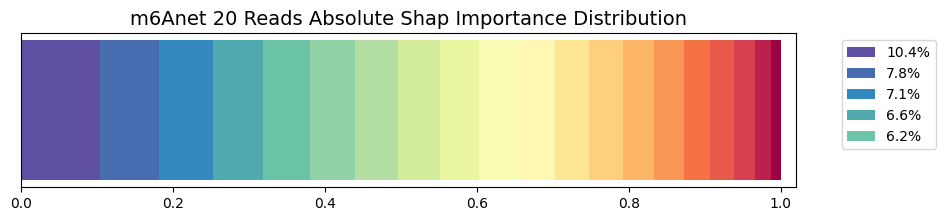

absolute shap gini for 20reads is: 0.22279584


In [42]:
shap_abs=abs(shap_values_20reads)
row_sums=shap_abs.sum(axis=1,keepdims=True)
normalized_shap_abs=shap_abs/row_sums
sorted_normalized_shap_abs=np.sort(normalized_shap_abs,axis=1)[:,::-1]

#importance distribution by the top N most important read by absolute shap
importance_20reads=sorted_normalized_shap_abs.mean(axis=0,keepdims=False)
print(importance_20reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_20reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_20reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_xlim([0,1.02])
ax.set_title('m6Anet 20 Reads Absolute Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/m6Anet_absolute_shap_distribution_20reads.pdf',bbox_inches='tight')
plt.show()

gini_20reads=gini_coefficient(importance_20reads)
print('absolute shap gini for 20reads is:',gini_20reads.cpu().numpy())

In [37]:
scaler=RobustScaler()

flattened_data=shap_values_20reads.flatten()
scaled_flattened_data=scaler.fit_transform(flattened_data.reshape(-1,1)).flatten()
scaled_shap_values_20reads=scaled_flattened_data.reshape(shap_values_20reads.shape)

pre_Y_list=[]
real_Y_list=[]
for i in range(len(scaled_shap_values_20reads)):
    c_X=sample_set_20reads[i].copy()
    for key in ['X','kmer']:
        c_X[key]=c_X[key].unsqueeze(0)
    pre_Y=model_20reads(c_X)[0].cpu().detach().numpy()
    pre_Y_list.append(pre_Y)
    real_Y=c_X['label'].cpu().detach().numpy()
    real_Y_list.append(real_Y)
    print('predicted label for sample',i,'is:',pre_Y)
    print('real label for sample',i,'is:',real_Y)
    print(f'shap_values for sample {i} is:\n {scaled_shap_values_20reads[i]}')
pre_Y_list=np.array(pre_Y_list)
real_Y_list=np.array(real_Y_list)

predicted label for sample 0 is: 0.929291
real label for sample 0 is: 1
shap_values for sample 0 is:
 [-3.577668 -3.806446  1.550404  0.62169  -3.806446  8.567173  1.550404
 -2.102527  3.083536 -0.162079 -2.102527 -0.162079 -3.673568  3.465142
  0.566431  4.223116 -3.673568  1.550404 -3.814381  8.567173]
predicted label for sample 1 is: 0.27383047
real label for sample 1 is: 0
shap_values for sample 1 is:
 [-0.005701 -0.010908 -0.009477 -0.010658 -0.01116  -0.007117 -0.010967
  0.003984 -0.009986 -0.01004  -0.009684 -0.004789 -0.007024 -0.011163
 -0.011146 -0.01083  -0.005483  0.285043 -0.010203 -0.009899]
predicted label for sample 2 is: 0.9577416
real label for sample 2 is: 1
shap_values for sample 2 is:
 [ 0.619487 -0.586501 -0.603125 -0.399408 -0.529914  2.189503 -0.443919
  1.131264  0.827358 -0.59471   0.134847 -0.580067 -0.593963 -0.398729
 -0.541124  1.106642 -0.59405  -0.108483 -0.571034 -0.316254]
predicted label for sample 3 is: 0.99387044
real label for sample 3 is: 1
shap_

Showing reads with the highest shap values and the status of its corrensponding sample.
Of top 20 shap values, 15 of them distributed in samples with a predicted value higher than 0.7
While of all 200 samples, 110 of them have a predicted value higher than 0.7


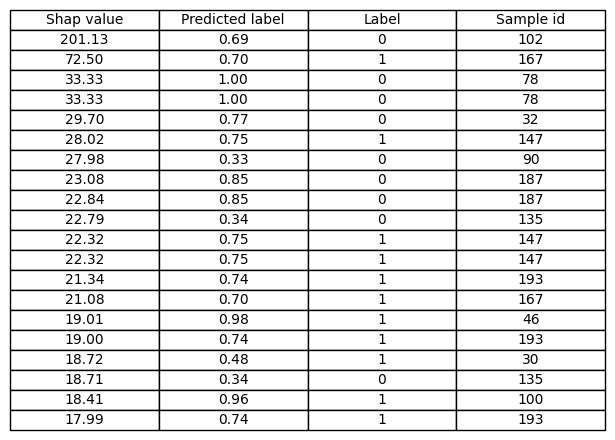

In [48]:
scaler=RobustScaler()
flattened_data=shap_values_20reads.flatten()
scaled_flattened_data=scaler.fit_transform(flattened_data.reshape(-1,1)).flatten()
scaled_shap_values_20reads=scaled_flattened_data.reshape(shap_values_20reads.shape)

pre_Y_list=[]
real_Y_list=[]
for i in range(len(scaled_shap_values_20reads)):
    c_X=sample_set_20reads[i].copy()
    for key in ['X','kmer']:
        c_X[key]=c_X[key].unsqueeze(0)
    pre_Y=model_20reads(c_X)[0].cpu().detach().numpy()
    pre_Y_list.append(pre_Y)
    real_Y=c_X['label'].cpu().detach().numpy()
    real_Y_list.append(real_Y)
pre_Y_list=np.array(pre_Y_list)
real_Y_list=np.array(real_Y_list)

TOP_N=20
Threshold=0.7
print('Showing reads with the highest shap values and the status of its corrensponding sample.')
flattened_shap_values_20reads=scaled_shap_values_20reads.flatten()
top_indices=np.argsort(flattened_shap_values_20reads)[-TOP_N:]
rows,cols=np.unravel_index(top_indices,scaled_shap_values_20reads.shape)
high_value_count=0


shap_list=[]
predicted_list=[]
label_list=[]
sample_list=[]
for row,col in zip(rows[::-1],cols[::-1]):
    shap_list.append(scaled_shap_values_20reads[row,col])
    predicted_list.append(pre_Y_list[row])
    label_list.append(real_Y_list[row])
    sample_list.append(row)
    if pre_Y_list[row]>=Threshold:
        high_value_count+=1
print(f'Of top {TOP_N} shap values, {high_value_count} of them distributed in samples with a predicted value higher than {Threshold}')
print(f'While of all {len(pre_Y_list)} samples, {(pre_Y_list>Threshold).sum()} of them have a predicted value higher than {Threshold}')

fig,ax=plt.subplots()
ax.axis('tight')
ax.axis('off')
column_names=('Shap value','Predicted label','Label','Sample id')
textdata=np.array([shap_list,predicted_list,label_list,sample_list]).T

formatted_data=[]
for row in textdata:
    formatted_row=[f'{val:.2f}' for val in row[:-2]] + [int(val) for val in row[-2:]]
    formatted_data.append(formatted_row)

table=ax.table(cellText=formatted_data,colLabels=column_names,loc='center')
for key,cell in table.get_celld().items():
    cell.set_text_props(ha='center',va='center')

table.scale(1.2,1.2)
plt.savefig('./edata/Save_drawing/m6Anet_shap_table.pdf',bbox_inches='tight')
plt.show()

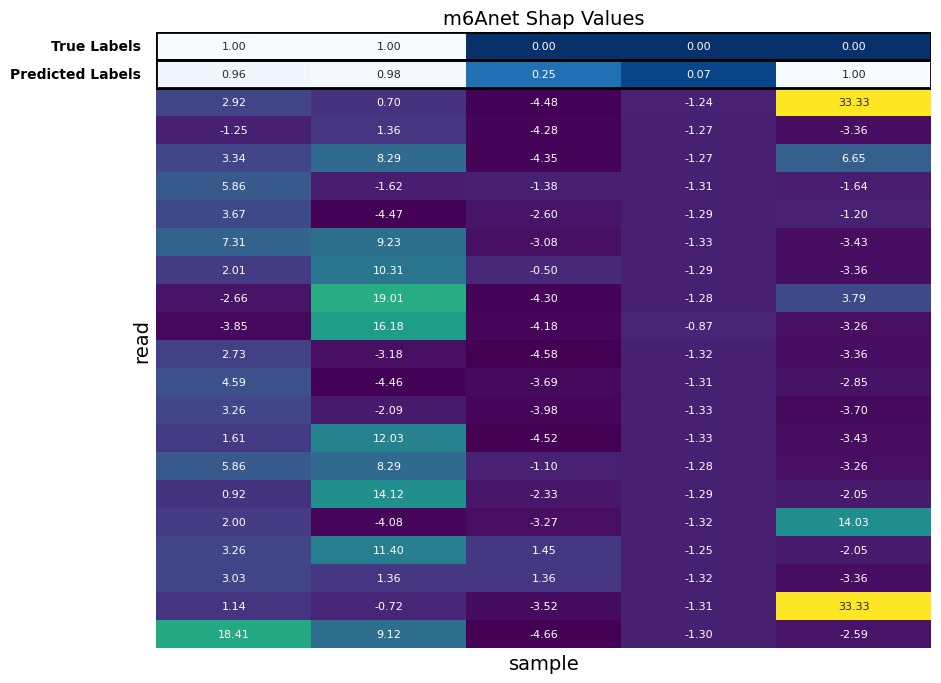

In [46]:
picked_for_showing=[100,46,44,80,78]

picked_real_Y=real_Y_list[picked_for_showing]
picked_pre_Y=pre_Y_list[picked_for_showing]
picked_reads_shap=scaled_shap_values_20reads[picked_for_showing].T
arr=np.vstack((picked_real_Y,picked_pre_Y,picked_reads_shap))

plt.figure(figsize=(10,8))

mask=np.zeros_like(arr,dtype=bool)
mask[2:]=True
sns.heatmap(arr, annot=True, fmt=".2f",cmap='Blues_r',cbar=False,annot_kws={"size":8}, mask=mask)
sns.heatmap(arr, annot=True, fmt=".2f",cmap='viridis',cbar=False,annot_kws={"size":8}, mask=~mask)
plt.text(-0.1,0.5,'True Labels',va='center',ha='right',fontsize=10,fontweight='bold',color='black')
plt.text(-0.1,1.5,'Predicted Labels',va='center',ha='right',fontsize=10,fontweight='bold',color='black')

rect1=Rectangle((0,0),arr.shape[1],1,linewidth=2,edgecolor='black',facecolor='none')
rect2=Rectangle((0,1),arr.shape[1],1,linewidth=2,edgecolor='black',facecolor='none')
ax=plt.gca()
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.set_xticks([])
ax.set_yticks([])

plt.title('m6Anet Shap Values',fontsize=14)
plt.xlabel('sample',fontsize=14)
plt.ylabel('read',fontsize=14)
plt.savefig('./edata/Save_drawing/m6Anet_shap_20reads_showcase.pdf',bbox_inches='tight')
plt.show()

# Shap explain 50reads

In [29]:
device=torch.device('cuda:0')
read_reduce=0

background_set_50reads=[]
sample_set_50reads=[]

background_set_size=1000
sample_set_size=200
shuffled_flattened_train_set=flattened_train_set[random.sample(range(len(flattened_train_set)),background_set_size)]
shuffled_flattened_test_set=flattened_test_set[random.sample(range(len(flattened_test_set)),sample_set_size)]

for i in range(background_set_size):
    ap_dic=shuffled_flattened_train_set[i].copy()
    for k,v in ap_dic.items():
        if k=='X' or k=='kmer':
            v=v[read_reduce:]
        v=v.to(device)
        ap_dic[k]=v
    background_set_50reads.append(ap_dic)

for i in range(sample_set_size):
    ap_dic=shuffled_flattened_test_set[i].copy()
    for k,v in ap_dic.items():
        if k=='X' or k=='kmer':
            v=v[read_reduce:]
        v=v.to(device)
        ap_dic[k]=v
    sample_set_50reads.append(ap_dic)

background_set_50reads=np.array(background_set_50reads)
sample_set_50reads=np.array(sample_set_50reads)

In [30]:
config_file_50reads='./ecode/m6Anet/m6Anet_50reads.toml'
model_config_50reads=toml.load(config_file_50reads)
model_config_50reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda:0')
model_50reads=MILModel(model_config_50reads).to(device)
model_50reads.load_state_dict(torch.load('./model/m6Anet_140_50reads_3sites.pkl',weights_only=True))

<All keys matched successfully>

In [31]:
explainer_50reads=m6Anet_DeepEXP(model_50reads,background_set_50reads)
shap_values_50reads=explainer_50reads.shap_values(sample_set_50reads)
shap_values_50reads=np.array(shap_values_50reads[0])
shap_values_50reads=shap_values_50reads.reshape(shap_values_50reads.shape[:-1])

[5.221407e-01 1.744701e-01 7.933383e-02 5.447043e-02 3.471762e-02
 2.586855e-02 2.021920e-02 1.487955e-02 1.066828e-02 8.543413e-03
 6.974179e-03 6.012590e-03 4.848809e-03 4.246739e-03 3.722527e-03
 3.226428e-03 2.751652e-03 2.327546e-03 2.037980e-03 1.850294e-03
 1.559395e-03 1.463783e-03 1.397268e-03 1.290176e-03 1.183317e-03
 1.072539e-03 1.008858e-03 8.948942e-04 8.533265e-04 7.988976e-04
 7.128468e-04 6.015270e-04 5.444483e-04 4.997402e-04 4.417897e-04
 3.944577e-04 3.617361e-04 3.267034e-04 2.732913e-04 2.478865e-04
 2.129079e-04 1.727506e-04 1.255011e-04 9.791082e-05 8.549499e-05
 4.794434e-05 2.006111e-05 6.111951e-08 0.000000e+00 0.000000e+00]


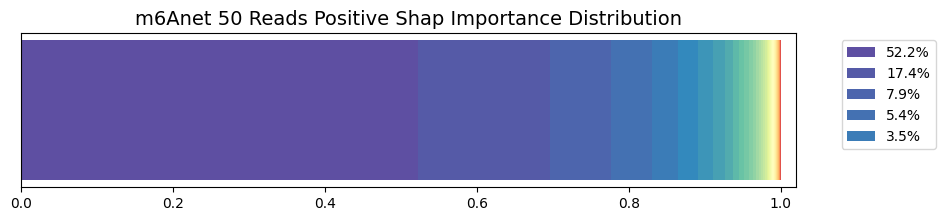

positive shap gini for 50reads is: 0.89549744


In [44]:
shap_use=shap_values_50reads.copy()
shap_use[shap_values_50reads<0]=0
row_sums=shap_use.sum(axis=1,keepdims=True)
row_sums[row_sums==0]=1
normalized_shap_use=shap_use/row_sums
sorted_normalized_shap_use=np.sort(normalized_shap_use,axis=1)[:,::-1]

#importance distribution by the top N most important read by positive shap
importance_50reads=sorted_normalized_shap_use.sum(axis=0,keepdims=False)/normalized_shap_use.sum()
print(importance_50reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_50reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_50reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_xlim([0,1.02])
ax.set_title('m6Anet 50 Reads Positive Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/m6Anet_positive_shap_distribution_50reads.pdf',bbox_inches='tight')
plt.show()

gini_50reads=gini_coefficient(importance_50reads)
print('positive shap gini for 50reads is:',gini_50reads.cpu().numpy())

[0.062341 0.03887  0.032859 0.031119 0.028514 0.027253 0.026471 0.025632
 0.025247 0.024735 0.024314 0.023978 0.023572 0.023271 0.02298  0.022647
 0.022282 0.021919 0.021655 0.02134  0.02108  0.020773 0.02048  0.020195
 0.019877 0.019565 0.019229 0.018933 0.018631 0.018305 0.017887 0.017501
 0.017118 0.016691 0.016259 0.015761 0.015326 0.014876 0.014363 0.01384
 0.013175 0.012437 0.011738 0.010982 0.010094 0.009327 0.008257 0.007046
 0.005625 0.003631]


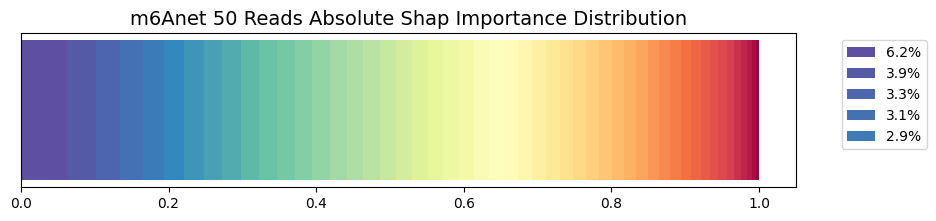

absolute shap gini for 50reads is: 0.2285347


In [40]:
shap_abs=abs(shap_values_50reads)
row_sums=shap_abs.sum(axis=1,keepdims=True)
normalized_shap_abs=shap_abs/row_sums
sorted_normalized_shap_abs=np.sort(normalized_shap_abs,axis=1)[:,::-1]

#importance distribution by the top N most important read by absolute shap
importance_50reads=sorted_normalized_shap_abs.mean(axis=0,keepdims=False)
print(importance_50reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_50reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_50reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_title('m6Anet 50 Reads Absolute Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/m6Anet_absolute_shap_distribution_50reads.pdf',bbox_inches='tight')
plt.show()

gini_50reads=gini_coefficient(importance_50reads)
print('absolute shap gini for 50reads is:',gini_50reads.cpu().numpy())